# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on 1.3 Million Cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1M brain cells with Unified Virtual Memory to oversubscribe GPU memory. See the README for instructions to download this dataset.

## Change to the notebooks directory

Change into the *notebooks* directory. You may need to modify your path depending on where you cloned the repo.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import dask
import time

import cudf
import cuml
import cupy as cp

import os, wget

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans

from dask_cuda import initialize, LocalCUDACluster
from dask.distributed import Client, default_client

import rapids_scanpy_funcs
import utils

import logging
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

cuml.__version__

'22.02.00'

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.



In [2]:
import rmm

def set_mem():
    rmm.reinitialize(managed_memory=True)
    cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

Set `preprocessing_gpus` below to specify the GPUs to use for preprocessing. For example, numbers 0-7 can be used on a machine with 8 gpus. Specifying a specific number, such as 5, will use only the 6th GPU on the machine. In practice, it's often a good idea to use GPUs 1-7 for pre-processing and GPU0 for downstream clustering, visualization, and differential gene expression steps. 

In [3]:
preprocessing_gpus="1, 2, 3, 4, 5, 6, 7"

In [4]:
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES=preprocessing_gpus)
client = Client(cluster)    

set_mem()
client.run(set_mem)

client

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 7,Total memory: 117.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44115,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 7
Started: Just now,Total memory: 117.93 GiB
Comm: tcp://127.0.0.1:38007,Total threads: 1
Dashboard: http://127.0.0.1:46821/status,Memory: 16.85 GiB
Nanny: tcp://127.0.0.1:45107,


## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [5]:
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [6]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

In [7]:
n_workers = len(client.scheduler_info()['workers'])

In [8]:
start = time.time()

## Load and Preprocess Data

In [9]:
data_load_preprocess_start = time.time()

Below, we load the sparse count matrix from the `.h5ad` file into GPU using a custom function. While reading the dataset, filters are applied on the count matrix to remove cells with an extreme number of genes expressed. Genes will zero expression in all cells are also eliminated. 

The custom function uses [Dask](https://dask.org) to partition data. The above mentioned filters are applied on individual partitions. Usage of Dask along with cupy provides the following benefits:
- Parallelized data loading when multiple GPUs are available
- Ability to partition the data allows pre-processing large datasets

Filters are applied on individual batches of cells. Elementwise or cell-level normalization operations are also performed while reading. For this example, the following two operations are performed:
- Normalize the count matrix so that the total counts in each cell sum to 1e4.
- Log transform the count matrix.

In [10]:
%%time
def partial_post_processor(partial_data):
    partial_data = rapids_scanpy_funcs.normalize_total(partial_data, target_sum=1e4)
    return partial_data.log1p()

dask_sparse_arr, genes, query = rapids_scanpy_funcs.read_with_filter(client,
                                                       input_file,
                                                       min_genes_per_cell=min_genes_per_cell,
                                                       max_genes_per_cell=max_genes_per_cell,
                                                       partial_post_processor=partial_post_processor)
dask_sparse_arr = dask_sparse_arr.persist()

CPU times: user 10.3 s, sys: 3.74 s, total: 14.1 s
Wall time: 1min 42s


# Verify the shape of the resulting sparse matrix:

In [11]:
dask_sparse_arr.shape

(1306127, 23619)

### Select Most Variable Genes

Before filtering the count matrix, we save the 'raw' expression values of the marker genes to use for labeling cells afterward.

In [12]:
%%time
marker_genes_raw = {}
i = 0
for index in genes[genes.isin(markers)].index.to_arrow().to_pylist():
    marker_genes_raw[markers[i]] = dask_sparse_arr[:, index].compute().toarray().ravel()
    i += 1

CPU times: user 2.29 s, sys: 458 ms, total: 2.75 s
Wall time: 11.8 s


Filter the count matrix to retain only the most variable genes.

In [13]:
%%time

hvg = rapids_scanpy_funcs.highly_variable_genes_filter(client, dask_sparse_arr, genes, n_top_genes=n_top_genes)

genes = genes[hvg]
dask_sparse_arr = dask_sparse_arr[:, hvg]
sparse_gpu_array = dask_sparse_arr.compute()

del hvg

CPU times: user 5.05 s, sys: 4.33 s, total: 9.37 s
Wall time: 13.6 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [14]:
%%time
sparse_gpu_array = sparse_gpu_array.tocsc()

mito_genes = genes.str.startswith(MITO_GENE_PREFIX).values
n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 939 ms, sys: 211 ms, total: 1.15 s
Wall time: 1.14 s


In [15]:
del sparse_gpu_array

And perform regression:

In [16]:
%%time
n_rows = dask_sparse_arr.shape[0]
n_cols = dask_sparse_arr.shape[1]
cols_per_worker = int(n_cols / n_workers)
dask_sparse_arr = dask_sparse_arr.map_blocks(lambda x: x.todense(), dtype="float32", meta=cp.array(cp.zeros((0,)))).T
dask_sparse_arr = dask_sparse_arr.rechunk((cols_per_worker, n_rows)).persist()
dask_sparse_arr.compute_chunk_sizes()

CPU times: user 1.2 s, sys: 564 ms, total: 1.76 s
Wall time: 19.1 s


dask.array<rechunk-merge, shape=(4000, 1291337), dtype=float32, chunksize=(571, 1291337), chunktype=cupy.ndarray>

In [17]:
%%time
import math
dask_sparse_arr = dask_sparse_arr.map_blocks(lambda x: rapids_scanpy_funcs.regress_out(x.T, n_counts, percent_mito).T, dtype="float32", meta=cp.array(cp.zeros(0,))).T
dask_sparse_arr = dask_sparse_arr.rechunk((math.ceil(n_rows/n_workers), n_cols)).persist()
dask_sparse_arr.compute_chunk_sizes()

CPU times: user 1.92 s, sys: 1.15 s, total: 3.08 s
Wall time: 31.3 s


dask.array<rechunk-merge, shape=(1291337, 4000), dtype=float32, chunksize=(186590, 4000), chunktype=cupy.ndarray>

### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [18]:
%%time
mean = dask_sparse_arr.mean(axis=0)
dask_sparse_arr -= mean
stddev = cp.sqrt(dask_sparse_arr.var(axis=0).compute())
dask_sparse_arr /= stddev
dask_sparse_arr = dask.array.clip(dask_sparse_arr, -10, 10).persist()
del mean, stddev

CPU times: user 668 ms, sys: 223 ms, total: 891 ms
Wall time: 9.28 s


In [19]:
data_load_preprocess_time = time.time()
print("Total data load and preprocessing time: %s" % (data_load_preprocess_time-data_load_preprocess_start))

Total data load and preprocessing time: 483.20719933509827


## Cluster & Visualize

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [20]:
%%time
from cuml.dask.decomposition import PCA
pca_data = PCA(n_components=50).fit_transform(dask_sparse_arr)
pca_data.compute_chunk_sizes()

CPU times: user 850 ms, sys: 336 ms, total: 1.19 s
Wall time: 13.9 s


dask.array<concatenate, shape=(1291337, 50), dtype=float32, chunksize=(186590, 50), chunktype=cupy.ndarray>

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [21]:
%%time
local_pca = pca_data.compute()
adata = anndata.AnnData(local_pca.get())

CPU times: user 2.53 s, sys: 556 ms, total: 3.09 s
Wall time: 5.82 s


In [22]:
del pca_data
del dask_sparse_arr

### t-SNE + K-means

We cluster the cells using k-means on the principal components. For example purposes, we set k=35.

In [23]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.X[:,:tsne_n_pcs])

[W] [21:01:54.860021] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 40.5 s, sys: 10.9 s, total: 51.4 s
Wall time: 50.6 s


In [24]:
%%time
from cuml.cluster import KMeans
kmeans_labels = KMeans(n_clusters=k, init="k-means||", random_state=0).fit_predict(local_pca)
adata.obs['kmeans'] = kmeans_labels.get().astype(str)

CPU times: user 1.76 s, sys: 14.1 ms, total: 1.77 s
Wall time: 1.8 s


We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

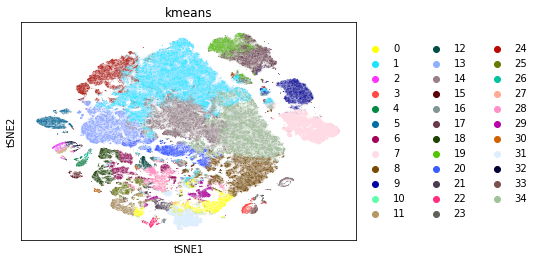

CPU times: user 10.8 s, sys: 2.53 s, total: 13.3 s
Wall time: 9.29 s


In [25]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

The UMAP function from Rapids is also integrated into Scanpy.

In [26]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 1min 58s, sys: 559 ms, total: 1min 59s
Wall time: 1min 56s


In [27]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 58.8 s, sys: 201 ms, total: 59 s
Wall time: 59 s


Next, we use the Louvain algorithm for graph-based clustering.

In [28]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 3.76 s, sys: 442 ms, total: 4.2 s
Wall time: 4.25 s


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

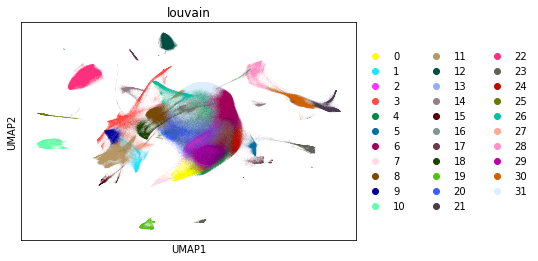

CPU times: user 9.32 s, sys: 459 ms, total: 9.78 s
Wall time: 9.17 s


In [29]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also use the Leiden clustering method in RAPIDS. This method has not been integrated into Scanpy and needs to be called separately.

In [30]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 2.49 s, sys: 334 ms, total: 2.82 s
Wall time: 2.74 s


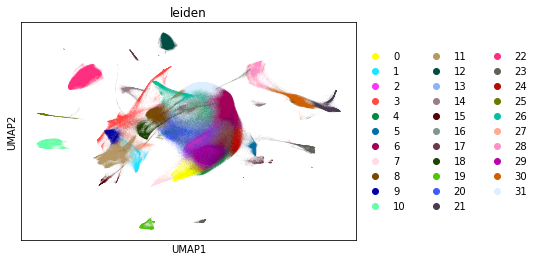

CPU times: user 9.11 s, sys: 528 ms, total: 9.64 s
Wall time: 8.98 s


In [31]:
%%time
sc.pl.umap(adata, color=["leiden"])

## Differential expression analysis

Once we have done clustering, we can compute a ranking for the highly differential genes in each cluster. Here we use the Louvain clusters as labels.

In [32]:
import cudf
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
genes = cudf.Series(genes)

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [33]:
genes

0                 Xkr4
3                Sox17
4              Gm37323
12               Oprk1
15       4732440D04Rik
             ...      
23601           mt-Nd6
23606       AC133103.1
23610       AC132444.6
23614       AC125149.3
23616             PISD
Length: 4000, dtype: object

In [34]:
%%time

import cupy as cp
scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    cp.array(adata.X), 
    cluster_labels, 
    genes, 
    n_genes=50, groups='all', reference='rest')

[W] [21:10:51.361004] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
CPU times: user 6.09 s, sys: 251 ms, total: 6.34 s
Wall time: 6.17 s


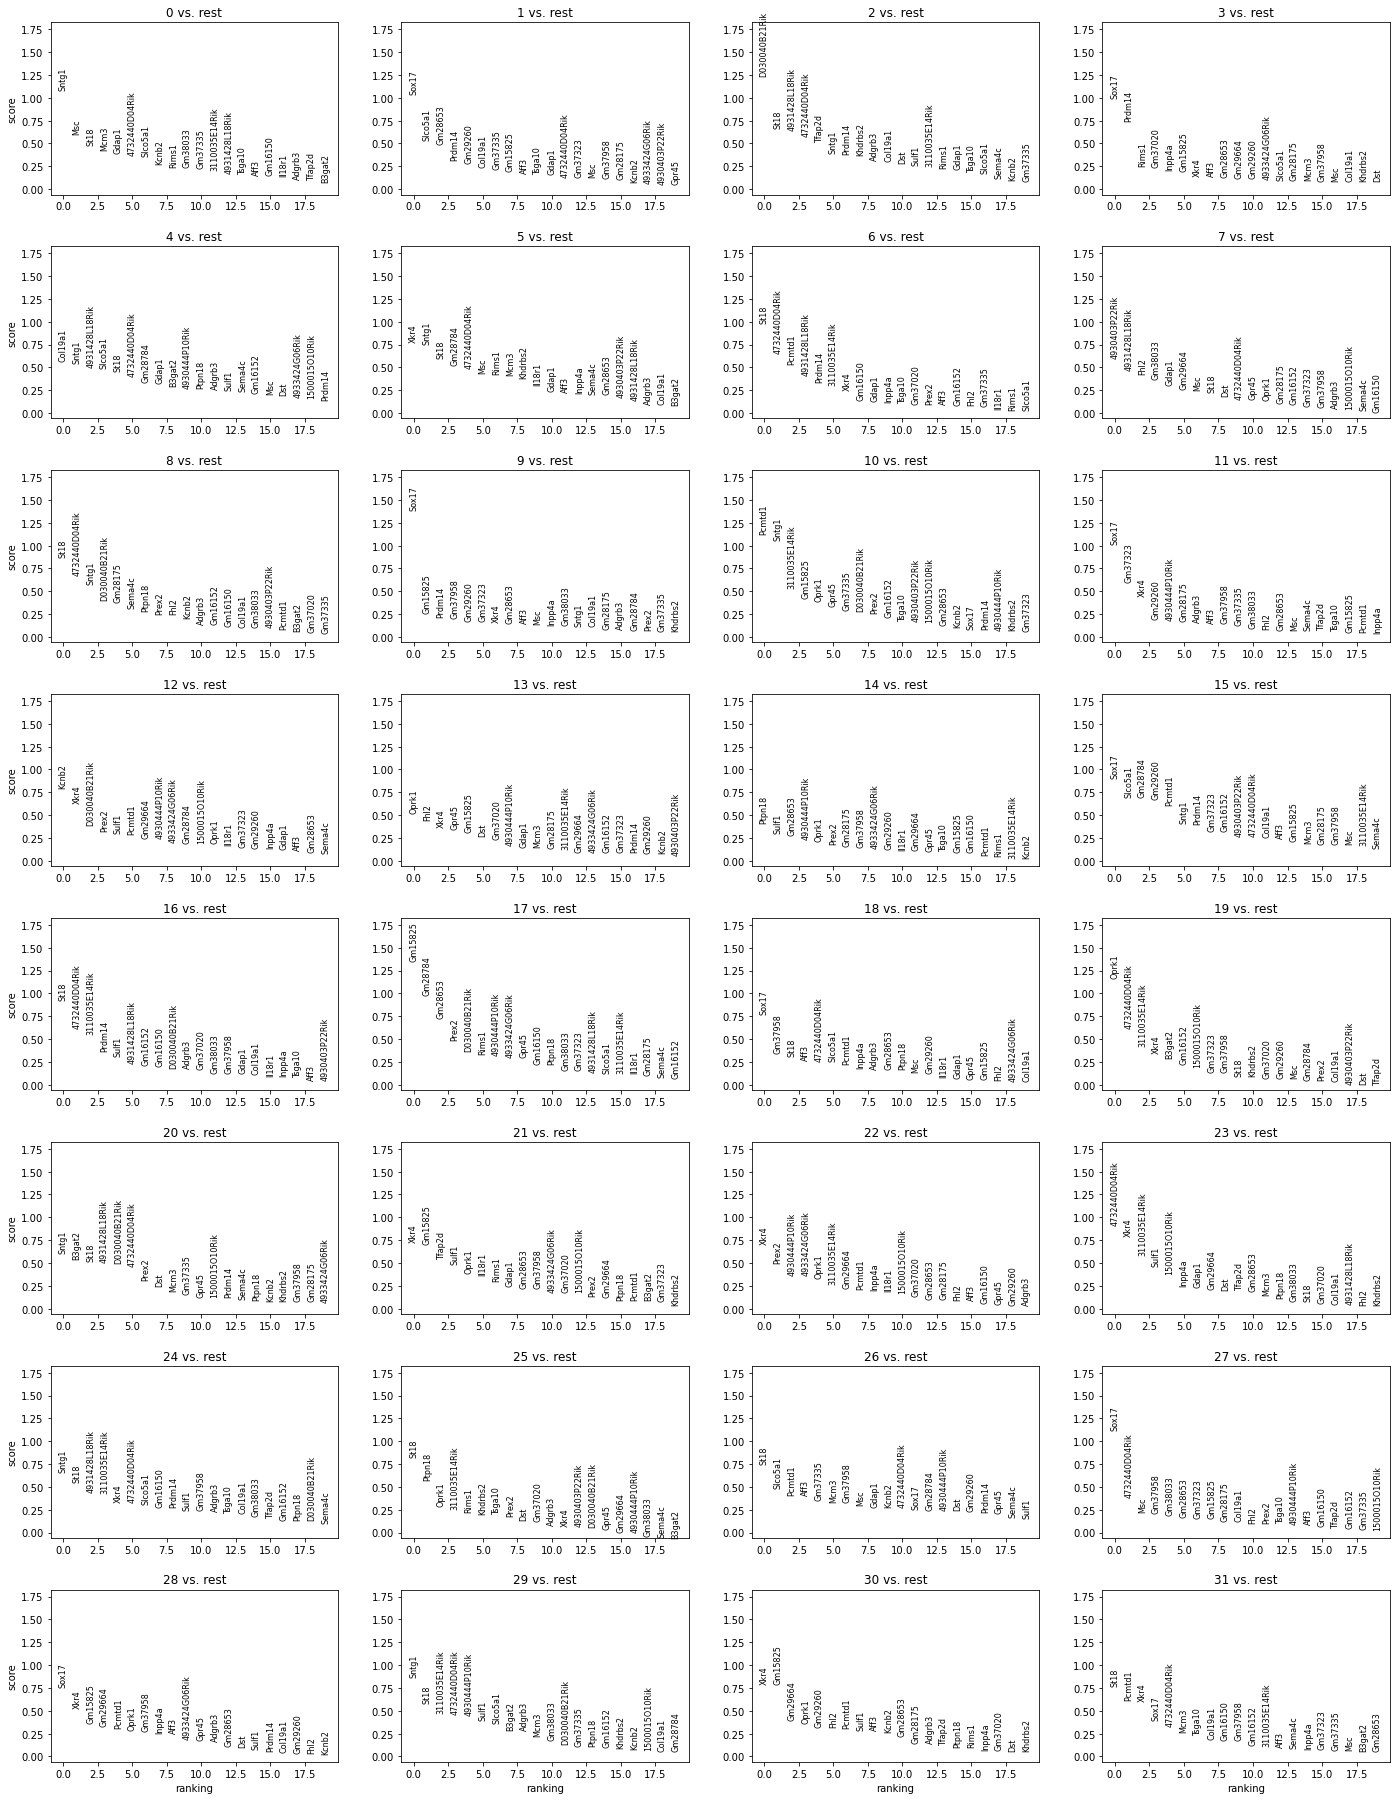

CPU times: user 6.23 s, sys: 680 ms, total: 6.91 s
Wall time: 6.24 s


In [35]:
%%time
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="louvain", method="logreg", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

In [36]:
print("Full time: %s" % (time.time() - start))

Full time: 1262.082351922989


In [37]:
client.shutdown()
cluster.close()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
